In [1]:
import astropy.units as u
import numpy as np
from BDFit import StarFit, find_bands, provide_phot
from astropy.table import Table
from astropy.io import fits, ascii
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import os
import glob
from astropy.coordinates import SkyCoord, Galactocentric
from astropy.wcs.utils import skycoord_to_pixel
from astropy.wcs import WCS
from astropy.visualization import LogStretch, ImageNormalize, AsymmetricPercentileInterval, LinearStretch

In [9]:
tab = Table.read('/nvme/scratch/work/tharvey/bagpipes/pipes/cats/GRB230207A-FULL/sfh_delayed_dust_Cal_uniform_Z_uniform_age_uniform_zfix.fits')

In [10]:
tab

#ID,delayed:age_16,delayed:age_50,delayed:age_84,delayed:massformed_16,delayed:massformed_50,delayed:massformed_84,delayed:metallicity_16,delayed:metallicity_50,delayed:metallicity_84,delayed:tau_16,delayed:tau_50,delayed:tau_84,dust:Av_16,dust:Av_50,dust:Av_84,nebular:logU_16,nebular:logU_50,nebular:logU_84,stellar_mass_16,stellar_mass_50,stellar_mass_84,formed_mass_16,formed_mass_50,formed_mass_84,sfr_16,sfr_50,sfr_84,ssfr_16,ssfr_50,ssfr_84,nsfr_16,nsfr_50,nsfr_84,mass_weighted_age_16,mass_weighted_age_50,mass_weighted_age_84,tform_16,tform_50,tform_84,tquench_16,tquench_50,tquench_84,sfr_10myr_16,sfr_10myr_50,sfr_10myr_84,ssfr_10myr_16,ssfr_10myr_50,ssfr_10myr_84,nsfr_10myr_16,nsfr_10myr_50,nsfr_10myr_84,UV_colour_16,UV_colour_50,UV_colour_84,VJ_colour_16,VJ_colour_50,VJ_colour_84,beta_C94_16,beta_C94_50,beta_C94_84,m_UV_16,m_UV_50,m_UV_84,M_UV_16,M_UV_50,M_UV_84,Halpha_EWrest_16,Halpha_EWrest_50,Halpha_EWrest_84,xi_ion_caseB_16,xi_ion_caseB_50,xi_ion_caseB_84,Halpha_flux_16,Halpha_flux_50,Halpha_flux_84,HBeta_flux_16,HBeta_flux_50,HBeta_flux_84,OIII_5007_flux_16,OIII_5007_flux_50,OIII_5007_flux_84,OIII_4959_flux_16,OIII_4959_flux_50,OIII_4959_flux_84,input_redshift,log_evidence,log_evidence_err,chisq_phot,n_bands
bytes19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
178_GRB230207A-FULL,6.528450249674237,9.180064539174094,11.600481863990947,9.751912473063618,9.911591650961109,10.057524066934583,0.08735219644797908,0.30612092359964893,0.6248360184877206,0.5514629184747695,1.6167931700922342,3.05195620428681,0.8669046617236594,1.096495634936737,1.4618546691759864,-2.6076489513507735,-1.892848726519163,-1.3055783431317982,9.448672778431192,9.584767016822095,9.704037622302003,9.751912473063618,9.911591650961109,10.057524066934583,0.0008207641952412612,0.10855773739999011,0.28927691868052025,-12.821947281004899,-10.57038724107619,-9.979520100285383,-3.056413771113885,-0.7953577211387177,-0.19113631215404134,4.399020030082936,5.955172303406664,7.694151102905141,4.906292404278143,6.64527120377662,8.201423477100347,9.007908834422377,99.0,99.0,0.0007839963064957133,0.1057836027519623,0.2854608597391245,-12.842292519080601,-10.579207944160192,-9.984714852860101,-3.096815523736739,-0.8081415240499839,-0.19509517546493738,1.5619932462544863,1.9364451738672228,2.165918735914403,1.257890728591472,1.4184688903843634,1.521763899998977,-1.0175056198774715,-0.5345499779489378,3.5999351881871844,22.382634926531413,23.840975127356586,27.5925220399932,-14.876507666408294,-13.418167465583121,-9.666620552946508,0.11811011279559236,13.772504467529949,32.36567542747994,2.8666493450055774e+24,8.938689119529492e+24,1.29595675362847e+25,1.842444039264896e-17,2.1033028992326876e-15,4.910553178403927e-15,6.614584720944548e-18,7.551920081644088e-16,1.752315132282859e-15,1.96902393727614e-17,2.8721497341136264e-15,7.580800199613847e-15,6.59954104234912e-18,9.626496858056653e-16,2.5407963582010895e-15,0.065,230.2000951728251,0.16539570623520874,3.8495869153811495,6.0


In [2]:
s = StarFit(['sonora_elf_owl', 'sonora_cholla', 'sonora_bobcat'])

Library path: /nvme/scratch/work/tharvey/brown_dwarfs/models
Warning! F410M found in multiple instruments. Keeping first, which is NIRCam. Provide instrument.band in dictionary to override this.
Total models: 39372


Known UNCOVER Brown Dwarfs

In [13]:
names = ['UNCOVER BD1', 'UNCOVER BD2', 'UNCOVER BD3']

coords_ra = [3.537529, 3.546420, 3.513891]
coords_dec = [-30.370169, -30.366245, -30.356024]

for i in range(len(names)):
    coords[i] = SkyCoord(ra=coords_ra[i], dec=coords_dec[i], unit=(u.deg, u.deg))
    print(names[i], coords[i].to_string('hmsdms'))
    
new_skycoord = SkyCoord(ra=[coord.ra.deg for coord in coords], dec=[coord.dec.deg for coord in coords], unit=(u.deg, u.deg))


UNCOVER BD1 00h14m09.00696s -30d22m12.6084s
UNCOVER BD2 00h14m11.1408s -30d21m58.482s
UNCOVER BD3 00h14m03.33384s -30d21m21.6864s


Fitting

In [4]:
cat_path = '/nvme/scratch/work/tharvey/catalogs/UNCOVER_DR3_LW_SUPER_catalog.fits'

table = Table.read(cat_path)

# Match the coordinates to the catalog
all_catalog = SkyCoord(table['ra'], table['dec'], unit='deg')
idx, sep, _ = new_skycoord.match_to_catalog_sky(all_catalog)

# Filter the catalog to only include the matched sources
table = table[idx]

bands = find_bands(table, flux_wildcard=f'f_*')

# Let's remove HST bands because of potential proper motion
bands_to_remove =  ['f435w','f606w','f814w','f814w','f105w', 'f125w', 'f140w', 'f160w', 'alma']
for band in bands_to_remove:
    bands.remove(band)

flux, error = provide_phot(bands=bands, flux_wildcard='f_*', error_wildcard='e_*', table=table, flux_unit=u.nJy)
# unit is 10*nJy
flux *= 10
error *= 10


In [5]:
s.fit_catalog(fnu=flux, efnu=error, bands=[band.upper() for band in bands], catalogue_ids=table['id']);

Warning! Assuming F435W is the same as ACS_WFC.F435W
Warning! Assuming F606W is the same as ACS_WFC.F606W
Warning! Assuming F814W is the same as ACS_WFC.F814W
Fitting with sonora_elf_owl, sonora_cholla, sonora_bobcat libraries with 39372 templates.
Fitting 23 bands: ['ACS_WFC.F435W', 'ACS_WFC.F606W', 'ACS_WFC.F814W', 'F070W', 'F090W', 'F115W', 'F140M', 'F150W', 'F162M', 'F182M', 'F200W', 'F210M', 'F250M', 'F277W', 'F300M', 'F335M', 'F356W', 'F360M', 'F410M', 'F430M', 'F444W', 'F460M', 'F480M']
(3, 23) (39372, 23) (39372, 23) (23, 39372) (3, 39372)


Calculating chi2 for all templates...: 100%|██████████| 39372/39372 [00:00<00:00, 63174.40it/s]


{'subset': None,
 'star_tnorm': array([[4.39519689e-01, 4.58885172e-01, 4.70862578e-01, ...,
         6.53552077e-04, 6.58127080e-04, 6.57432199e-04],
        [5.52704654e-01, 5.72713989e-01, 5.84692934e-01, ...,
         3.41267029e-04, 3.44079346e-04, 3.44319801e-04],
        [2.36451430e+00, 2.52714898e+00, 2.60416139e+00, ...,
         3.75679114e-04, 3.77353167e-04, 3.69291189e-04]]),
 'star_chi2': array([[418.2088  , 440.45068 , 449.9808  , ...,  87.107605,  85.30279 ,
          88.79172 ],
        [269.93878 , 304.94498 , 319.75314 , ..., 298.16483 , 295.8914  ,
         296.89987 ],
        [ 59.911175,  89.98927 , 102.13079 , ..., 148.5172  , 147.82802 ,
         150.57323 ]], dtype=float32),
 'star_min_ix': array([25950, 19916,  8988]),
 'star_min_chi2': array([11.970302 ,  5.2342224,  2.6722791], dtype=float32),
 'star_min_chinu': array([0.63001588, 0.27548539, 0.2969199 ])}

Plot their SEDs

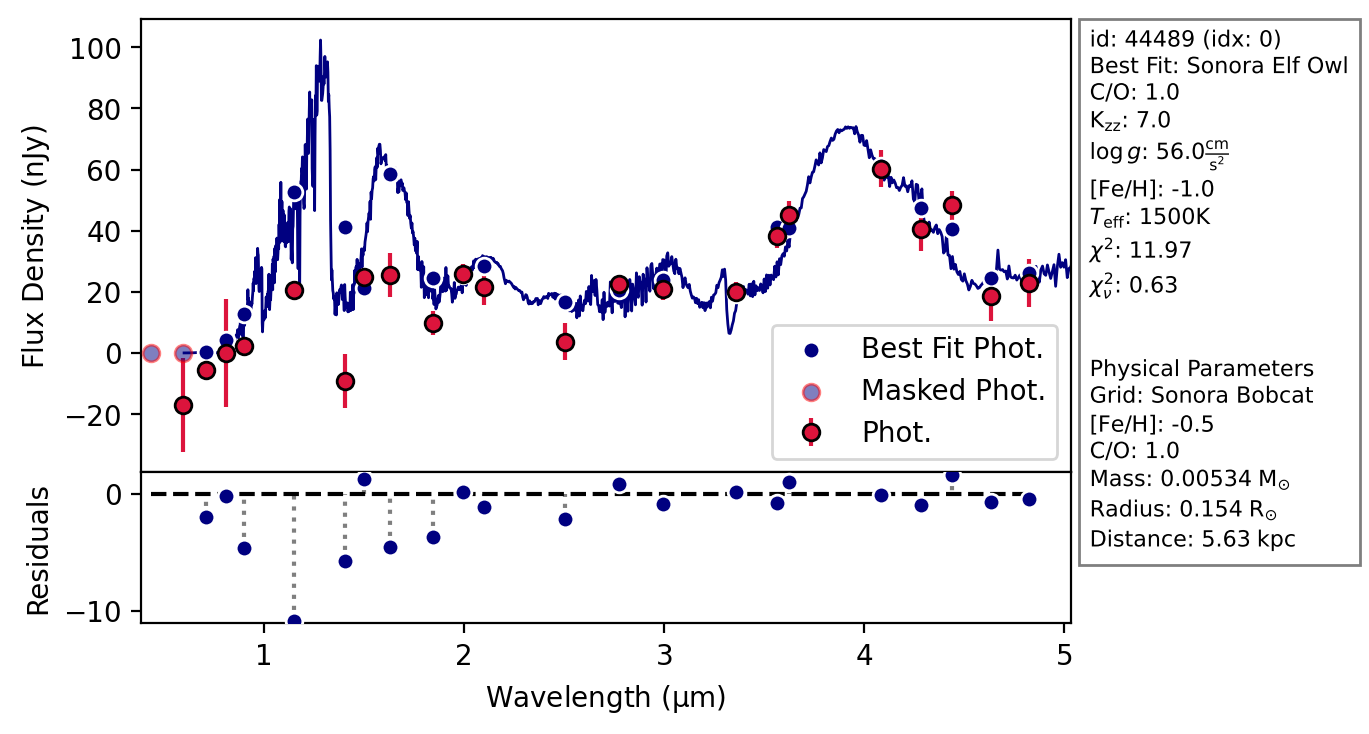

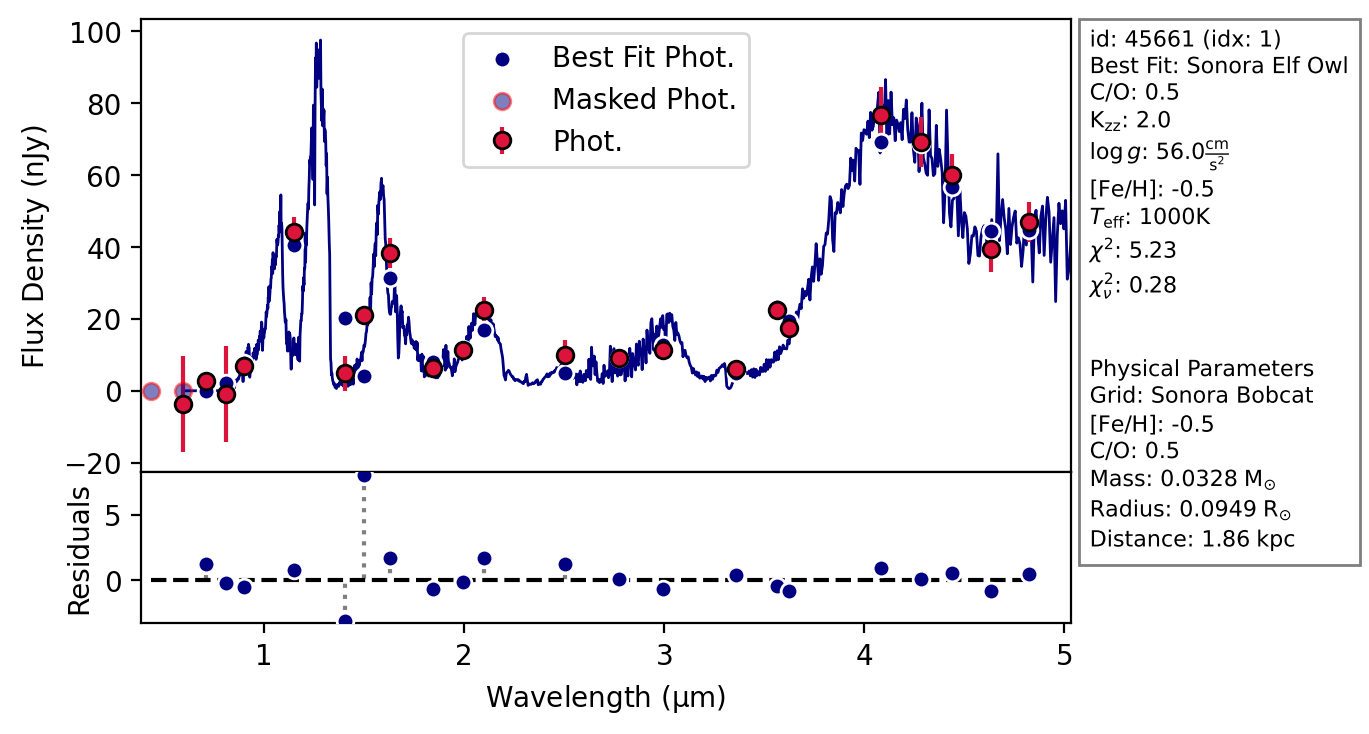

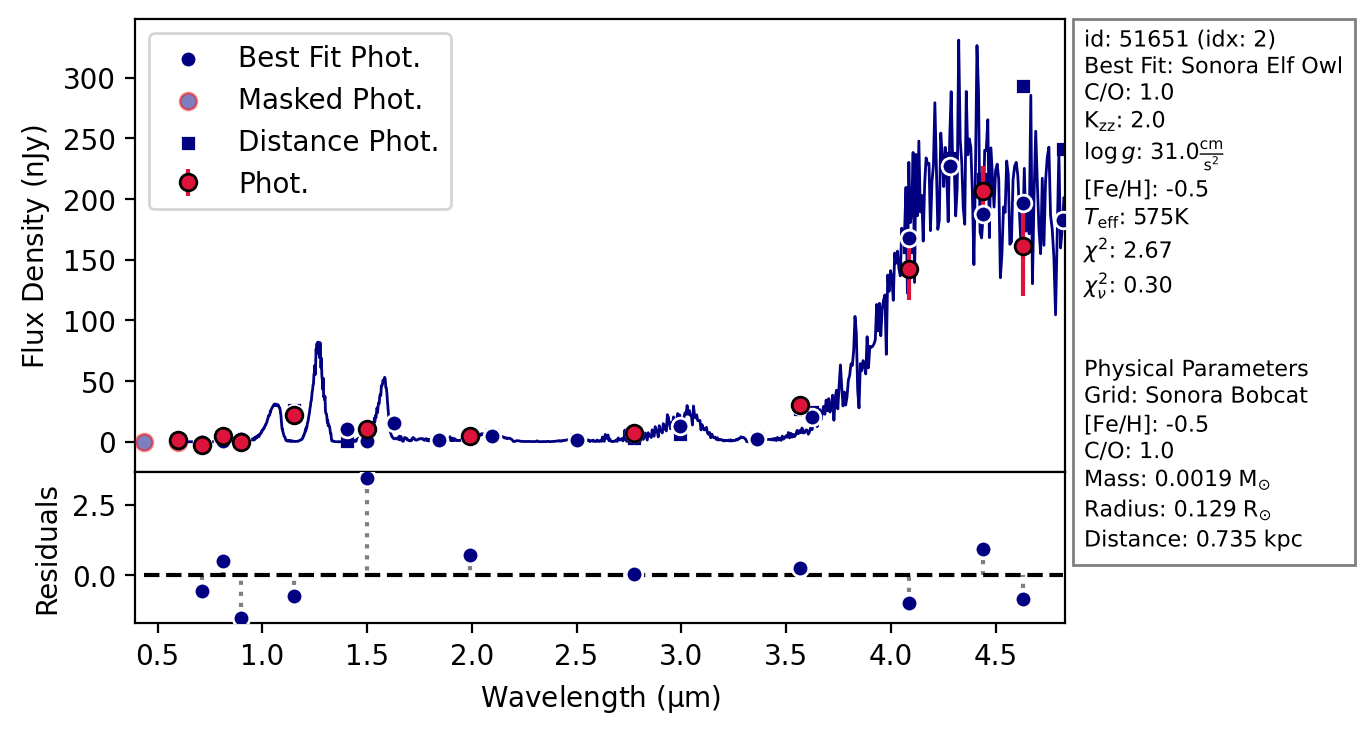

In [6]:
%matplotlib inline

for id in table['id']:
    s.plot_fit(cat_id=id, flux_unit=u.nJy, test_scale=1)
    

In [7]:
# Reduced chi2 less than 1, S/N in any 3 bands greater than 5, and all 27 filters used

mask = (s.star_min_chinu < 0) & (np.sum(flux.value/error.value > 8, axis=1) > 3) & (s.nusefilt > 15)
ids = np.arange(len(s.star_min_chinu))[mask]
print(len(ids))
for i in ids:
    s.plot_fit(idx=i, flux_unit=u.nJy)


0


In [8]:
#%matplotlib ipympl
'''
ras = table['ra'][mask]
decs = table['dec'][mask]

s.plot_brown_dwarf_locations(idxs=ids, ra=ras, dec=decs, coord_system='galactocentric', plot_3d=False)

'''

"\nras = table['ra'][mask]\ndecs = table['dec'][mask]\n\ns.plot_brown_dwarf_locations(idxs=ids, ra=ras, dec=decs, coord_system='galactocentric', plot_3d=False)\n\n"

IndexError: index 0 is out of bounds for axis 0 with size 0

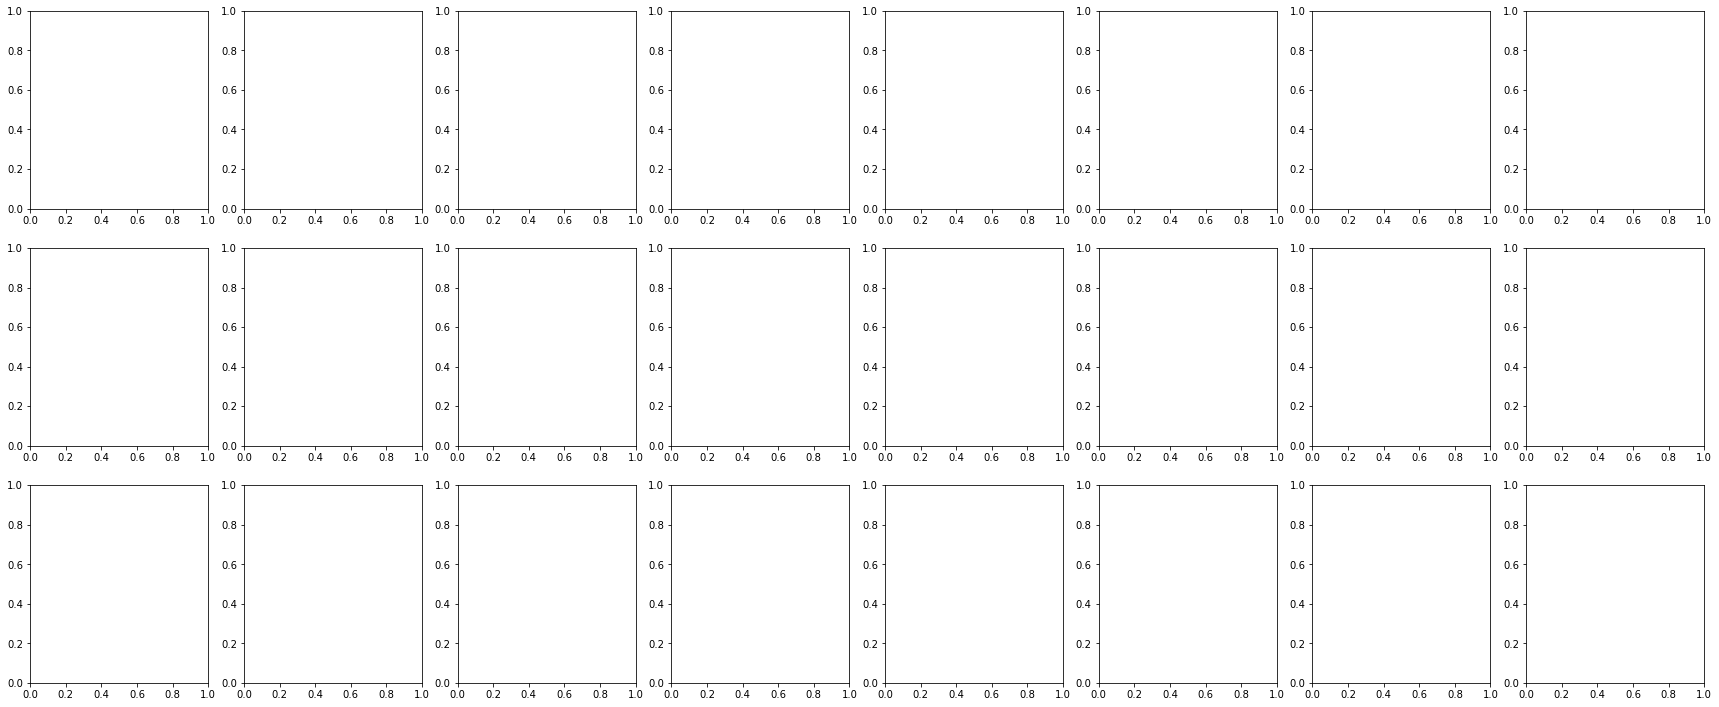

In [9]:
%matplotlib inline

image_folder = '/raid/scratch/data/jwst/UNCOVER/UNCOVER_DR3'

cutout_size_as = 2 * u.arcsec
id = 29562
scale = LinearStretch()

nrows = 3
fig, ax = plt.subplots(nrows, int(np.ceil(len(bands)/nrows)), figsize=(4*len(bands)//nrows, 4.12*nrows))

ax = ax.flatten()

def uncover_cutout(band, image_folder):
    image_name = f'{image_folder}/abell2744clu-grizli-v7.2-{band.lower()}-clear_drc_sci.fits'
    alt_image_name = f'{image_folder}/abell2744clu-grizli-v7.0-{band.lower()}_drz_sci.fits'
    alt_image_name2 = f'{image_folder}/abell2744clu-grizli-v7.1-{band.lower()}_drc_sci.fits'

    if os.path.exists(alt_image_name):
        image_name = alt_image_name
    elif os.path.exists(alt_image_name2):
        image_name = alt_image_name2

    if not os.path.exists(image_name):
        print(image_name)
        add = False
        return False, False, add, False, False
    else:
        add = True
    hdu = fits.open(image_name)
    header = hdu[0].header
    wcs_im = WCS(header)
    
    pixel_scale = np.abs(hdu[0].header['CD1_1']) * u.deg
    cutout_size = int(cutout_size_as / pixel_scale)


    ra_coord = table['ra'][table['id'] == id]
    dec_coord = table['dec'][table['id'] == id]
    sky_pos = SkyCoord(ra_coord, dec_coord)                        
    pixel_coords = skycoord_to_pixel(sky_pos, wcs_im)
    x, y = pixel_coords[0][0], pixel_coords[1][0]
    data = np.array(hdu[0].section[int(y-cutout_size/2):int(y+cutout_size/2), int(x-cutout_size/2):int(x+cutout_size/2)])
    # get only middle 10x10 pixels
    data_crop = data[cutout_size//2-5:cutout_size//2+5, cutout_size//2-5:cutout_size//2+5]
    return data, data_crop, add, header, (x, y)

ax_pos = 0
for pos, band in enumerate(bands):

    data, data_crop, add, _, _ = uncover_cutout(band, image_folder)
    if data is False:
        continue

    norm = ImageNormalize(data_crop, stretch=scale, interval=AsymmetricPercentileInterval(1, 98))
    ax[ax_pos].imshow(data, norm=norm, cmap='viridis', origin='lower')
    
    ax[ax_pos].text(0.95, 0.95, band.upper(), color='white', ha='right', va='top', transform=ax[ax_pos].transAxes, fontsize=32,
                    path_effects=[pe.withStroke(linewidth=2, foreground='black')])
    
    ax[ax_pos].axis('off')    
    if add:
        ax_pos += 1


for i in range(ax_pos, len(ax)):
    fig.delaxes(ax[i])

# Remove horizontal space between axes
plt.subplots_adjust(hspace=0, wspace=0)

(array(15767.57729711), array(13680.96847658)) [53.47145221 55.64896557]
Distance between the two centroids is 0.12565349827280065 arcsec
Time difference between the two observations is 4627 days
Angular velocity is 0.009918941051251445 arcsec/year
Transverse velocity is 159.8695200821521 km / s


Text(0.05, 0.05, '$\\delta t = 4627 \\ \\mathrm{days}$\n$\\delta \\theta = $$0.126\\mathrm{{}^{\\prime\\prime}}$\n$\\mathrm{v}_{\\mathrm{trans}}=$$160 \\; \\mathrm{km\\,s^{-1}}$')

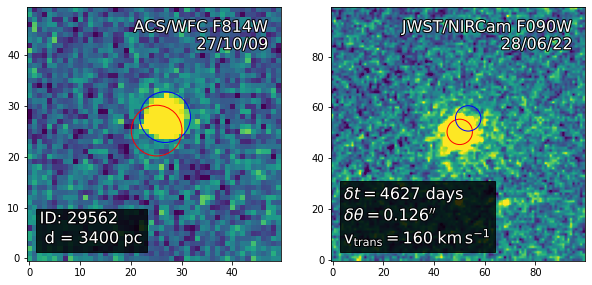

In [ ]:
first_band = 'F090W'
second_band = 'F814W'

data_first, _, _, header_first, first_center = uncover_cutout(first_band, image_folder)
data_second, _, _, header_second, second_center = uncover_cutout(second_band, image_folder)

# Get centroid of both

wcs_first = WCS(header_first)
wcs_second = WCS(header_second)


from photutils.centroids import centroid_com, centroid_1dg, centroid_2dg

centroid_first = centroid_2dg(data_first)
centroid_second = centroid_2dg(data_second)

# Convert to sky coordinates

# Need to correct for WCS offsets - first_center and second_center are the cutout centers. Need to calculate positions in full image - i,e centroid_first -middle + first_center

center_first_corr = first_center[0] + centroid_first[0] - np.shape(data_first)[0]//2, first_center[1] + centroid_first[1] - np.shape(data_first)[1]//2
center_second_corr = second_center[0] + centroid_second[0] - np.shape(data_second)[0]//2, second_center[1] + centroid_second[1] - np.shape(data_second)[1]//2



sky_first = wcs_first.pixel_to_world(center_first_corr[0], center_first_corr[1])
sky_second = wcs_second.pixel_to_world(center_second_corr[0], center_second_corr[1])    

centroid_second_on_first = wcs_first.world_to_pixel(sky_second) - np.array(first_center) + np.array(np.shape(data_first))//2

print(wcs_first.world_to_pixel(sky_second), centroid_second_on_first)

# Get distance between the two

distance = sky_first.separation(sky_second)

print(f'Distance between the two centroids is {distance.to(u.arcsec)}')

date_first = header_first['DATE-OBS'] 
date_second = header_second['DATE-OBS']

# Calculate time difference between the two

from datetime import datetime

date_format = '%Y-%m-%d'
date_first = datetime.strptime(date_first, date_format)
date_second = datetime.strptime(date_second, date_format)

time_diff = date_first - date_second 

print(f'Time difference between the two observations is {time_diff.days} days')

print(f'Angular velocity is {distance.to(u.arcsec).value / (time_diff.days / 365.25)} arcsec/year')


distance_physical = 3400 * u.pc 


# Calculate transverse velocity given distance and angular velocity - theta = v*t

projected_distance_physical = distance_physical * distance.to(u.rad)

projected_distance_physical = projected_distance_physical.value * u.pc
time_seconds = time_diff.total_seconds() * u.s

transverse_velocity = projected_distance_physical / time_seconds
print(f'Transverse velocity is {transverse_velocity.to(u.km/u.s)}')

# Make a plot of second on first image

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

norm = ImageNormalize(data_first, stretch=scale, interval=AsymmetricPercentileInterval(1, 98))
ax[1].imshow(data_first, norm=norm, cmap='viridis', origin='lower')

# Show positon of first and second centroid with circle

from matplotlib.patches import Circle

circle = Circle((centroid_first[0], centroid_first[1]), 5, edgecolor='red', facecolor='none')

ax[1].add_patch(circle)

circle = Circle((centroid_second_on_first[0], centroid_second_on_first[1]), 5, edgecolor='blue', facecolor='none')

ax[1].add_patch(circle)

norm = ImageNormalize(data_second, stretch=scale, interval=AsymmetricPercentileInterval(1, 98))
ax[0].imshow(data_second, norm=norm, cmap='viridis', origin='lower')

circle = Circle((centroid_second[0], centroid_second[1]), 5, edgecolor='blue', facecolor='none')

ax[0].add_patch(circle)

centroid_first_on_second = wcs_second.world_to_pixel(sky_first) - np.array(second_center) + np.array(np.shape(data_second))//2

circle = Circle((centroid_first_on_second[0], centroid_first_on_second[1]), 5, edgecolor='red', facecolor='none')

ax[0].add_patch(circle)

# Label with band and date

ax[1].text(0.95, 0.95, f'JWST/NIRCam {first_band.upper()}\n{date_first:%d/%m/%y}', color='white', ha='right', va='top', transform=ax[1].transAxes, fontsize=16,
                    path_effects=[pe.withStroke(linewidth=2, foreground='black')])

ax[0].text(0.95, 0.95, f'ACS/WFC {second_band.upper()}\n{date_second:%d/%m/%y}', color='white', ha='right', va='top', transform=ax[0].transAxes, fontsize=16,
                    path_effects=[pe.withStroke(linewidth=2, foreground='black')])

ax[0].text(0.05, 0.05, f'ID: {id}\n d = {np.round(distance_physical, 0):latex}', color='white', ha='left', va='bottom', transform=ax[0].transAxes, fontsize=16,
                    path_effects=[pe.withStroke(linewidth=2, foreground='black')], bbox=dict(facecolor='black', edgecolor='black', alpha=0.8))

ax[1].text(0.05, 0.05, f'$\delta t = {time_diff.days} \ \mathrm{{days}}$\n$\delta \\theta = ${np.round(distance.to(u.arcsec), 3):latex}\n$\mathrm{{v}}_{{\mathrm{{trans}}}}=${np.round(transverse_velocity.to(u.km/u.s), 0):latex_inline}', color='white', ha='left', va='bottom', transform=ax[1].transAxes, fontsize=16,
                    path_effects=[pe.withStroke(linewidth=2, foreground='black')], bbox=dict(facecolor='black', edgecolor='black', alpha=0.8))



Match known UNCOVER Brown Dwarfs

0.017395146940631975


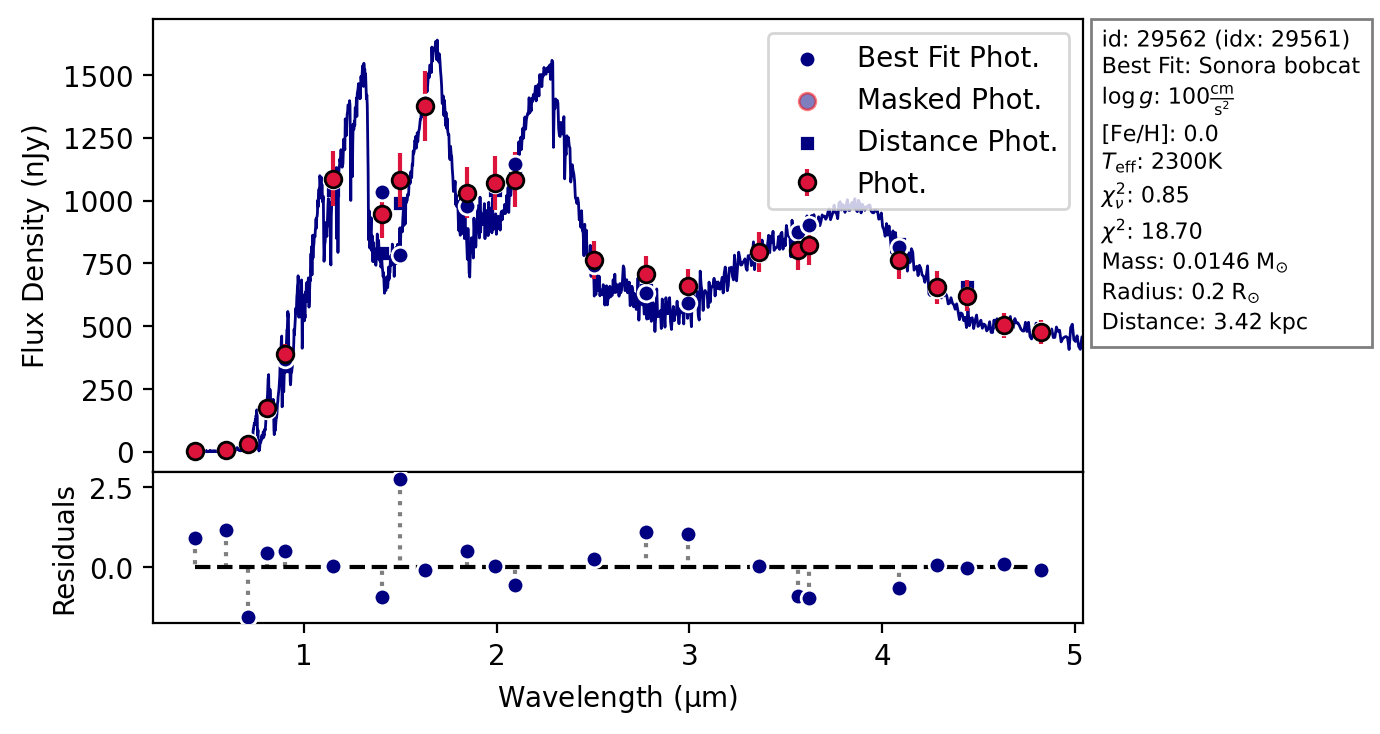

In [ ]:
s.plot_fit(cat_id=29562, test_scale=1);

In [ ]:
import numpy as np
import astropy.units as u
from astropy import constants as const


def vega_to_ab_conversion(wavelengths, vega_spectrum, filter_transmission):
    """
    Calculate Vega to AB magnitude conversion for a given filter.
    
    Parameters:
    wavelengths: Array of wavelengths in Angstroms
    vega_spectrum: Vega spectrum flux density (erg/s/cm^2/A)
    filter_transmission: Filter transmission curve
    
    Returns:
    Conversion factor (m_AB - m_Vega)
    """

    vega_flux_fnu = vega_flux.to(u.Jy, equivalencies=u.spectral_density(wavelengths))

    print(wavelengths, vega_flux_fnu)
    
    vega_filtered = np.trapz(vega_flux_fnu * filter_transmission*wavelengths, wavelengths)
    transmission = np.trapz(filter_transmission*wavelengths, wavelengths)

    bandpass_flux = vega_filtered / transmission
    bandpass_flux = bandpass_flux.to(u.Jy, equivalencies=u.spectral_density(wavelengths))

    return -2.5 * np.log10(bandpass_flux.value) + 8.90


library = 'ATMO2020'
kzz_type = 'CEQ'

path = f'{s.library_path}/{library}/models/evolutionary_tracks/ATMO_{kzz_type}/JWST_photometry/JWST_phot_NIRCAM_modAB_mean/'
# folder
files = glob.glob(f'{path}/*')
tables = []
paths = []
filter = 'F090W'


vega_file = '/nvme/scratch/work/tharvey/brown_dwarfs/models/ATMO2020/models/vega_spectrum/alpha_lyr_mod_001.fits'

vega_tab = Table.read(vega_file, units=[None, None], format='fits')

vega_flux = vega_tab['FLUX'].data * u.erg/u.s/u.cm**2/u.AA
vega_wav = vega_tab['WAVELENGTH'].data * u.AA
transmission = s.transmission_profiles[filter]

print(transmission[0], vega_wav)

# resample transmission profile onto wavelength grid of vega
transmission = np.interp(vega_wav.to(u.AA).value, transmission[0], transmission[1])

conversion = vega_to_ab_conversion(vega_wav, vega_flux, transmission)
print(conversion)


vega_mag = tab[f'NIRCAM-{filter}']

distance = 1000 * u.pc
for file in files[:1]:
    tab = ascii.read(file)

    ab_mag = vega_mag + conversion






[ 7835.5  7845.5  7855.5  7865.5  7875.5  7885.5  7895.5  7905.5  7915.5
  7925.5  7935.5  7945.5  7955.5  7965.5  7975.5  7985.5  7995.5  8005.5
  8015.5  8025.5  8035.5  8045.5  8055.5  8065.5  8075.5  8085.5  8095.5
  8105.5  8115.5  8125.5  8135.5  8145.5  8155.5  8165.5  8175.5  8185.5
  8195.5  8205.5  8215.5  8225.5  8235.5  8245.5  8255.5  8265.5  8275.5
  8285.5  8295.5  8305.5  8315.5  8325.5  8335.5  8345.5  8355.5  8365.5
  8375.5  8385.5  8395.5  8405.5  8415.5  8425.5  8435.5  8445.5  8455.5
  8465.5  8475.5  8485.5  8495.5  8505.5  8515.5  8525.5  8535.5  8545.5
  8555.5  8565.5  8575.5  8585.5  8595.5  8605.5  8615.5  8625.5  8635.5
  8645.5  8655.5  8665.5  8675.5  8685.5  8695.5  8705.5  8715.5  8725.5
  8735.5  8745.5  8755.5  8765.5  8775.5  8785.5  8795.5  8805.5  8815.5
  8825.5  8835.5  8845.5  8855.5  8865.5  8875.5  8885.5  8895.5  8905.5
  8915.5  8925.5  8935.5  8945.5  8955.5  8965.5  8975.5  8985.5  8995.5
  9005.5  9015.5  9025.5  9035.5  9045.5  9055.5  9

NameError: name 'tab' is not defined

In [ ]:
2.5 * np.log10(3631)

8.90006562228223

In [ ]:
fits.open('/nvme/scratch/work/tharvey/brown_dwarfs/models/ATMO2020/models/vega_spectrum/alpha_lyr_mod_001.fits')[0].header



SIMPLE  =                    T /                                                
BITPIX  =                   16 /                                                
NAXIS   =                    0 /                                                
EXTEND  =                    T /FITS extensions present?                        
SOURCE  = 'Bohlin, R. C. 2014, AJ, submitted' /                                 
COMMENT = 'Created by R. Bohlin from Kurucz Special Model' /                    
TEFFGRAV= '        '           /Teff/log g for model                            
DESCRIP = 'MODEL Fluxes ------------------------------------------------------' 
DBTABLE = 'CRSPECTRUM'         /                                                
TARGETID= 'ALPHA_LYR_MOD'      /                                                
AIRMASS =              0.00000 /mean airmass of the observation                 
USEAFTER= 'Jan 01 2000 00:00:00' /                                              
PEDIGREE= 'MODEL   '        

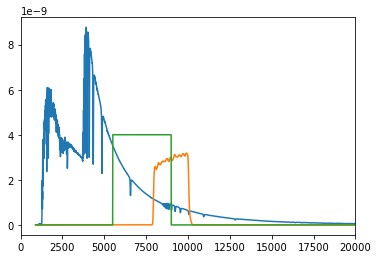

In [ ]:
plt.plot(vega_wav, vega_flux)
plt.xlim(0, 20000)

# plot transmission profile on top 

plt.plot(vega_wav, transmission/1e8)

# Add a V-band filter

V_band = [5500, 9000] * u.AA

V_transmission = np.zeros(len(vega_wav))
V_transmission[(vega_wav > V_band[0]) & (vega_wav < V_band[1])] = 4e-9

plt.plot(vega_wav, V_transmission)


In [ ]:
vega_wav


<Quantity [8.9945099e+02, 9.0035303e+02, 9.0125500e+02, ..., 2.9935320e+06,
           2.9965328e+06, 2.9995370e+06] Angstrom>

In [ ]:
import synphot

In [ ]:
!pip install sbpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.4 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for sbpy: filename=sbpy-0.5.0-py3-none-any.whl size=484000 sha256=8e277114cb38041d3a5754cd6c472efb236254c3614b41f2e2e4400a39ed9b79
  Stored in directory: /nvme/scratch/work/tharvey/pip/cache/wheels/f9/db/da/7f585b50ab925231394c8a4e44c687bcdea93318c48836b0a5
Successfully built sbpy

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
import sbpy.units

sbpy.units.enable() 

In [ ]:
from sbpy.units import VEGAmag, spectral_density_vega
from synphot import SpectralElement             

bp = SpectralElement.from_file('/nvme/scratch/work/tharvey/brown_dwarfs/src/BDFit/filters/F090W.csv')  


In [ ]:
m = 0.0 * VEGAmag

fluxd = m.to(u.ABmag, spectral_density_vega(bp))

fluxd

<Magnitude 0.51356023 mag(AB)>